## Loading in the data

In [29]:
# import external libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import ase.io
from ase.visualize import view


In [30]:
# import the data

energies = np.load("./data/energies.npy")
features_2b = np.load("./data/features_2b.npy")
features_3b = np.load("./data/features_3b.npy")
configurations = ase.io.read("./original_dataset/methane.extxyz",format="extxyz", index = "0:10")


In [31]:
print(np.shape(energies))

(120000,)


There are 12000 energy values in the energy dataset

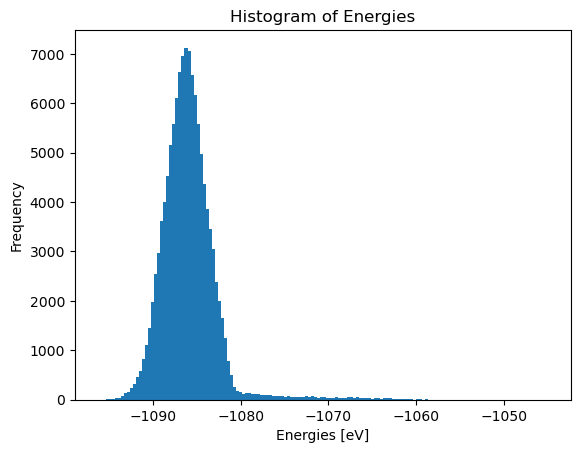

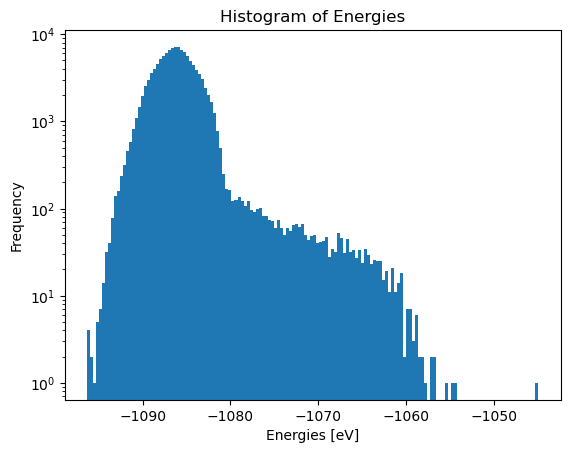

In [32]:
# plot the energies to get a first visualizeation of the the data
n_bins = 150

plt.hist(energies, bins=n_bins)
plt.xlabel("Energies [eV]")
plt.ylabel("Frequency")
plt.title("Histogram of Energies")
plt.show()

plt.hist(energies, bins=n_bins)
plt.xlabel("Energies [eV]")
plt.ylabel("Frequency")
plt.title("Histogram of Energies")
plt.yscale("log")
# plt.xscale("log")
plt.show()

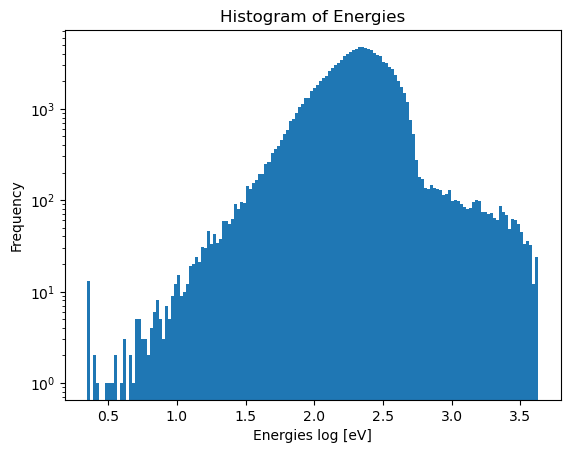

In [33]:
# log transform the energies

energies_log = np.log(energies - energies.min()  + 1e-10)
energies_log = winsorize(energies_log, limits=[0.0001, 0.0001])
plt.hist(energies_log, bins=n_bins)
plt.xlabel("Energies log [eV]")
plt.ylabel("Frequency")
plt.title("Histogram of Energies")
plt.yscale("log")
# plt.xscale("log")
plt.show()

In [34]:
mean = np.mean(energies)
std = np.std(energies)

print(f"The mean energy is {mean:.3f} and the standard deviation is {std:.3f}")

The mean energy is -1085.934 and the standard deviation is 3.216


From the histogram we see that there there are a couple structures with very high energy values, these are probably outliers. The data is also quite skewed in its distribution. Using a naive ML model could be significantly skewed by these values. 
We should probably start by looking at these structures to have a idea of how reasonable these values are and remove the outlier values. 
We can also use a log transformation to reduce the skew in the data, 

In [35]:
# Find the structures with highest and lowest energies

min_energy_struc = np.argmin(energies)
max_energy_struc = np.argmax(energies)

In [36]:
configuration_min = ase.io.read("./original_dataset/methane.extxyz",format="extxyz", index = f"{min_energy_struc}")

configuration_max = ase.io.read("./original_dataset/methane.extxyz",format="extxyz", index = f"{max_energy_struc}")

In [37]:
# Examples of the values and data that we can get out using ase

print(configurations[1])
print(configurations[1].get_total_energy()) # energy is in Hartrees here (a.u)
print(configurations[1].get_forces()) # forces are in Hartrees/Bohr here (a.u)
print(configurations[1].get_positions())
print(configurations[1].get_pbc())
print(configurations[1].get_chemical_formula())

Atoms(symbols='CH4', pbc=False, calculator=SinglePointCalculator(...))
-40.00215330819545
[[-0.03581802 -0.00420251 -0.00715774]
 [-0.02522427  0.05106136  0.01209057]
 [-0.04816886 -0.06129081  0.00255791]
 [ 0.03800681 -0.01462905  0.0142425 ]
 [ 0.07119975  0.02906308 -0.02173035]]
[[ 0.          0.          0.        ]
 [ 0.83552005 -1.71310156 -0.76561295]
 [ 0.90331127  1.4685474  -0.17934739]
 [-1.61007917  0.51011817 -0.93935798]
 [-1.5602297  -0.37013976  0.43731466]]
[False False False]
CH4


Because of the skew in the data and the couple very high values, using the RMSE will probably result in a high loss 

In [38]:
view(configurations[1], viewer="x3d")

In [39]:
print("Structure with the lowest energy")
view(configuration_min, viewer="x3d")


Structure with the lowest energy


In [40]:
print("Structure with the highest energy")
view(configuration_max, viewer = "x3d")

Structure with the highest energy


Looking at the structures we understand why they have their respective energies.
In the structure with the highest energy, two of the hydrogen atoms are practically in the carbon atom, which significantly increases the energy of the structure
In the structure with the lowest energy, the hydrogen atoms are further from the carbon atom and the hydrogen atoms are equally spread out aronf the carbon atom.

In [41]:
print(features_2b.shape)
print(features_3b.shape)


(120000, 16)
(120000, 1584)


There are 16 2-body features and XX 3 body features

For a dataset with N structure and M features, $ \textbf{y} = X \textbf{w} + \varepsilon$. with y dimensions Nx1, X dimensions NxM, and w dimensions Mx1. 
Equation is $X^T (y - Xw) = 0 \rightarrow X^T X w = X^T y  \rightarrow w = (X^T X )^{-1}$ X^T t$
The computational complexity of $X^TX$ is M²N. THe complexity of inverting the resulting MxM matrix is M^3. The complexity of then multiplying this matrix with X^T is then M²N. So the total complexity is of $O(M²N +M³)